In [1]:
import numpy as np
from matplotlib.axes._axes import Axes
from numpy import ndarray
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas import DataFrame
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('Heart Attack Analysis & Prediction Dataset.csv')

## Data Exploration

In [3]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
df.nunique()

age          41
sex           2
cp            4
trtbps       49
chol        152
fbs           2
restecg       3
thalachh     91
exng          2
oldpeak      40
slp           3
caa           5
thall         4
output        2
dtype: int64

## Identifying possible categorical features

In [6]:
possible_categorical = df.nunique().index[df.nunique() < 10]
categorical_to_transform = []
categorical_to_show = {}
print(len(possible_categorical))
possible_categorical

9


Index(['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output'], dtype='object')

sex:  It represents the patient's biological sex.  It's usually encoded as 0 for female and 1 for male. 

In [7]:
# no need to work with this feature
# categorical_to_transform.append('sex')
sex = df['sex']
categorical_to_show['sex'] = df['sex'].apply(lambda x: 'female' if x == 0 else 'male')
sex.value_counts()

sex
1    207
0     96
Name: count, dtype: int64

cp:  This stands for "chest pain type."  It describes the kind of chest pain the patient experienced.  There are typically four categories:

- 0: Typical angina (pain behind the breastbone)
- 1: Atypical angina (not exactly fitting the typical angina pattern)
- 2: Non-anginal pain (chest pain not related to angina)
- 3: Asymptomatic (no chest pain reported). 



In [8]:
def show_categorical_violin_plots(data_to_show: dict[str, pd.Series], y_column: str, axes: Axes = None):
    if axes is None:
        rows = np.ceil(np.sqrt(len(data_to_show))).astype(int)
        cols = np.ceil(len(data_to_show) / rows).astype(int)
        
        fig, ax = plt.subplots(figsize=(16, 6), ncols=rows, nrows=cols)
    else:
        ax = axes
        rows, cols = ax.shape
    for i, (feature, data) in enumerate(data_to_show.items()):
        data_df = pd.DataFrame({feature: data, y_column: df[y_column]})
        data_df_melted = pd.melt(data_df, y_column, var_name=feature)
        if type(ax) != ndarray:
            ax = np.array([ax])
        if len(ax.shape) == 1:
            ax = ax.reshape(ax.size,1)
        sns.violinplot(x=feature, y='value', hue=y_column, data=data_df_melted, inner='quartile',
                       ax=ax[i // cols, i % cols], split=True)
        ax[i // cols, i % cols].set_title(f'Violin plot of {feature} vs {y_column}')
    plt.show()

In [9]:
categorical_to_transform.append('cp')

cp = df['cp'].map({0: 'typical_angina', 1: 'atypical_angina', 2: 'non-anginal_pain', 3: 'asymptomatic'})

categorical_to_show['cp'] = cp
# fig, ax = plt.subplots(figsize=(16, 6),ncols=2, nrows=1)
# print(ax.size,type(ax))
# 
# cp_df_melted = pd.melt(cp_df, 'output', var_name='cp feature')
# 
# sns.violinplot(x='cp feature', y='value', hue='output', data=cp_df_melted, inner='quartile', ax=ax[1], split=True)
# plt.title('Violin plot of Chest Pain Type vs Output')
# plt.show()
# show_categorical_violin_plots(categorical_to_show, 'output')

cp = pd.get_dummies(cp)
cp.head(2)

,asymptomatic,atypical_angina,non-anginal_pain,typical_angina
0,True,False,False,False
1,False,False,True,False


fbs:  This is "fasting blood sugar." It indicates whether the patient's fasting blood sugar is greater than 120 mg/dl.  It's usually encoded as 0 (false) or 1 (true).

In [10]:
## no need to work with this feature
df['fbs'].value_counts()
categorical_to_show['fbs'] = df['fbs'].apply(lambda x: 'fbs > 120' if x == 1 else 'fbs <= 120')

restecg:  This refers to "resting electrocardiograph results." It describes the findings of an ECG taken while the patient is at rest.  Common categories include:

- 0: Normal
- 1: ST-T wave abnormality (can range from mild to significant)
- 2: Left ventricular hypertrophy (enlarged heart muscle). Categorical.

In [11]:
categorical_to_transform.append('restecg')
restecq = df['restecg'].map({0: 'normal', 1: 'ST-T_abnormality', 2: 'left_ventricular_hypertrophy'})
categorical_to_show['restecg'] = restecq
restecg = pd.get_dummies(restecq, drop_first=True)
restecg.value_counts()

left_ventricular_hypertrophy  normal
False                         False     152
                              True      147
True                          False       4
Name: count, dtype: int64

exng:  This means "exercise-induced angina."  It indicates whether the patient experiences chest pain during exercise.  Usually encoded as 0 (no) or 1 (yes)

In [12]:
## no need to work with this feature
df['exng'].value_counts()
categorical_to_show['exng'] = df['exng'].apply(lambda x: 'angina' if x == 1 else 'no_angina')

slp: This likely refers to "slope of the peak exercise ST segment". It describes the slope of a certain part of the ECG during exercise. The ST segment is related to the heart's electrical recovery.  It's often categorized:

- 0: Upsloping
- 1: Flat
- 2: Downsloping 

In [13]:
categorical_to_transform.append('slp')
slp = df['slp'].map({0: 'upsloping', 1: 'flat', 2: 'downsloping'})
categorical_to_show['slp'] = slp
slp = pd.get_dummies(slp, drop_first=True)
slp.value_counts()

flat   upsloping
False  False        142
True   False        140
False  True          21
Name: count, dtype: int64

caa:  This stands for "number of major vessels colored by fluoroscopy." It refers to the number of major blood vessels supplying the heart that have significant narrowing or blockages, as visualized during a coronary angiography procedure.

**Categorical ? or discrete?**
> I'm not a doctor, so IDK and to be honest IDC. So, I'll treat it as numerical 

In [14]:
categorical_to_show['caa'] = df['caa'].apply(lambda x: f'{x} vessels')
df['caa'].value_counts()

caa
0    175
1     65
2     38
3     20
4      5
Name: count, dtype: int64

thall:  This is short for "thallium stress test." It indicates the results of a nuclear stress test that uses thallium to assess blood flow to the heart muscle.  Common categories include:

- Normal blood flow. If the two sets of images match and look healthy, you have normal blood flow.
- Abnormal blood flow during exercise. If your images show that part of your heart isn’t getting enough blood flow after exercise, you have a blocked or narrowed artery. This means you have coronary artery disease.
- Low blood flow during both rest and exercise. If the image shows that part of your heart isn’t getting enough blood during both rest and exercise, you may have a severe blockage. An angioplasty or a stent might be needed to remove the blockage.
- No thallium visible in parts of the heart. If there is no radioactive dye visible in a certain part of your heart, this is a sign of damage from a heart attack. 

In [15]:
categorical_to_transform.append('thall')
thall = df['thall'].map({0: 'normal', 1: 'abnormal_exercise', 2: 'low_blood_flow', 3: 'no_thallium'})
categorical_to_show['thall'] = thall
thall = pd.get_dummies(thall, drop_first=True)
thall.value_counts()

low_blood_flow  no_thallium  normal
True            False        False     166
False           True         False     117
                False        False      18
                             True        2
Name: count, dtype: int64

In [16]:
print(f"Categorical features to transform: {categorical_to_transform}")
print(f"Posible features without modifications: {set(possible_categorical) - set(categorical_to_transform)}")
transformed_features = [cp, restecg, slp, thall]

Categorical features to transform: ['cp', 'restecg', 'slp', 'thall']
Posible features without modifications: {'caa', 'output', 'exng', 'sex', 'fbs'}


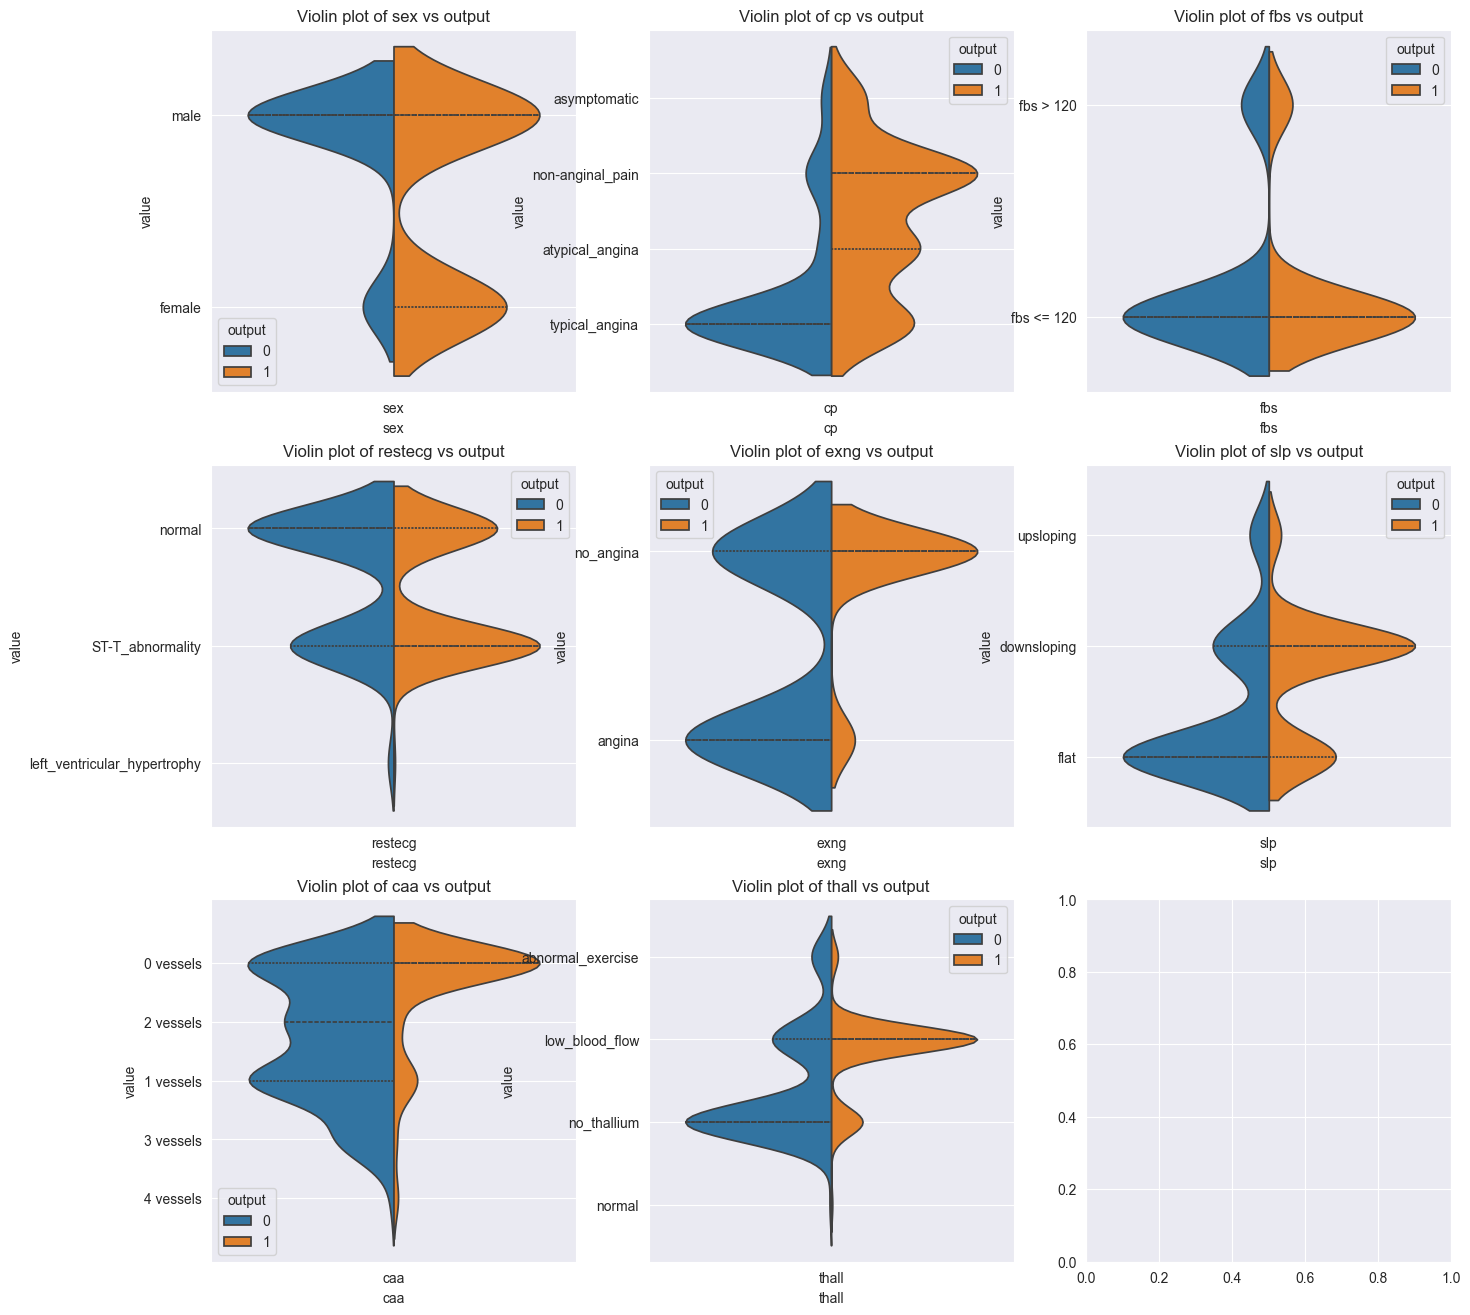

In [17]:
fig, ax = plt.subplots(figsize=(16, 16),ncols=3, nrows=3)
show_categorical_violin_plots(categorical_to_show, 'output', ax)

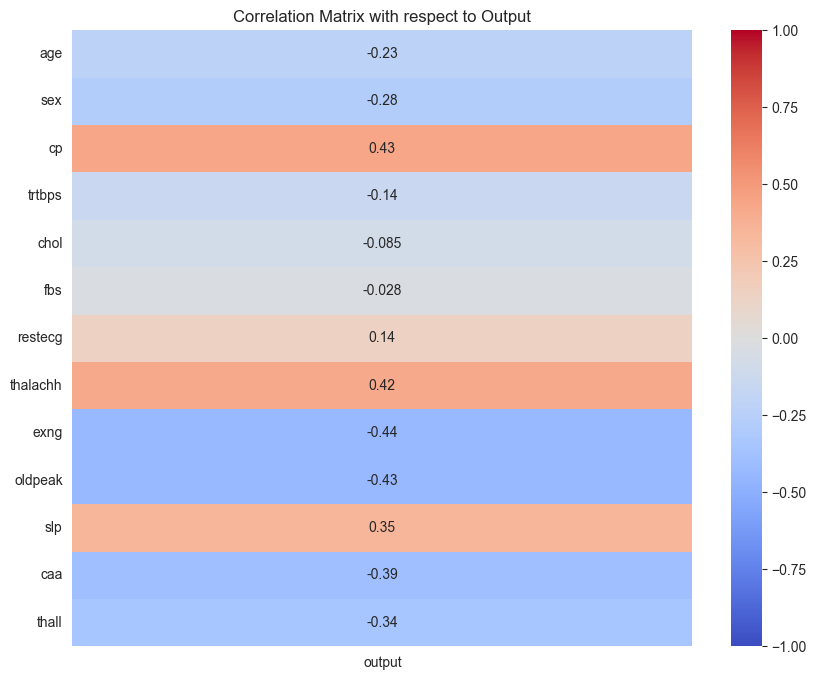

In [18]:
# Assuming the output column is named 'output'
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Extract the correlation values with respect to the 'output' column
output_correlation = correlation_matrix[['output']].drop('output')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(output_correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix with respect to Output')
plt.show()

In [19]:
print(len(df.columns))
df.columns

14


Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output'],
      dtype='object')

In [20]:
numerical_columns = set(df.columns) - set(possible_categorical) - set(['output'])
df[list(numerical_columns)].head(2)

,thalachh,oldpeak,age,chol,trtbps
0,150,2.3,63,233,145
1,187,3.5,37,250,130


In [21]:
scaler = StandardScaler()
df[list(numerical_columns)] = scaler.fit_transform(df[list(numerical_columns)])
df[list(numerical_columns)].head(2)

,thalachh,oldpeak,age,chol,trtbps
0,0.015443,1.087338,0.952197,-0.256334,0.763956
1,1.633471,2.122573,-1.915313,0.072199,-0.092738


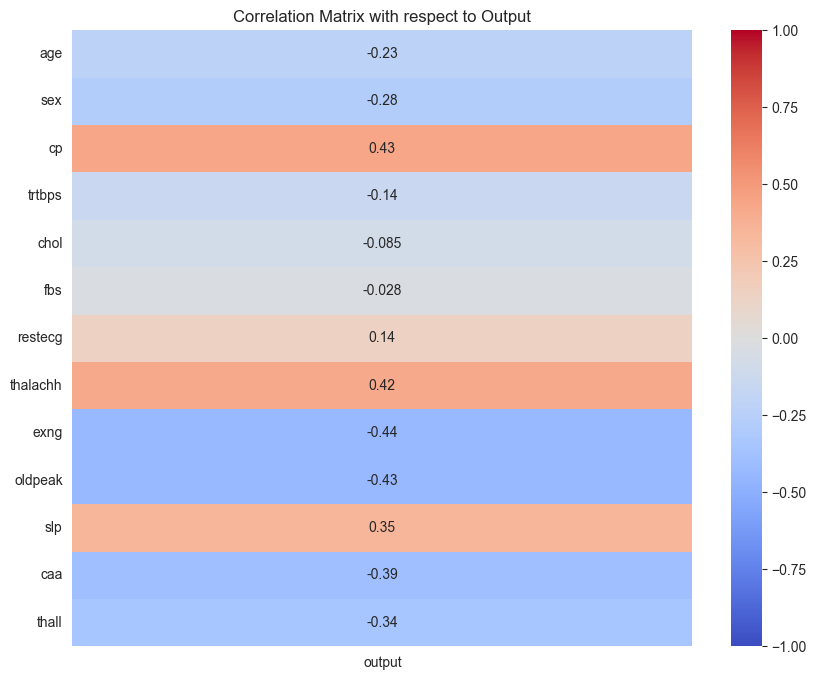

In [22]:
correlation_matrix = df.corr()
output_correlation = correlation_matrix[['output']].drop('output')
plt.figure(figsize=(10, 8))
sns.heatmap(output_correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix with respect to Output')
plt.show()

In [23]:
df = pd.concat([df, *transformed_features], axis=1)
df.drop(columns=categorical_to_transform, inplace=True)
df.head(2)

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,caa,output,...,atypical_angina,non-anginal_pain,typical_angina,left_ventricular_hypertrophy,normal,flat,upsloping,low_blood_flow,no_thallium,normal
0,0.952197,1,0.763956,-0.256334,1,0.015443,0,1.087338,0,1,...,False,False,False,False,True,False,True,False,False,False
1,-1.915313,1,-0.092738,0.072199,0,1.633471,0,2.122573,0,1,...,False,True,False,False,False,False,True,True,False,False


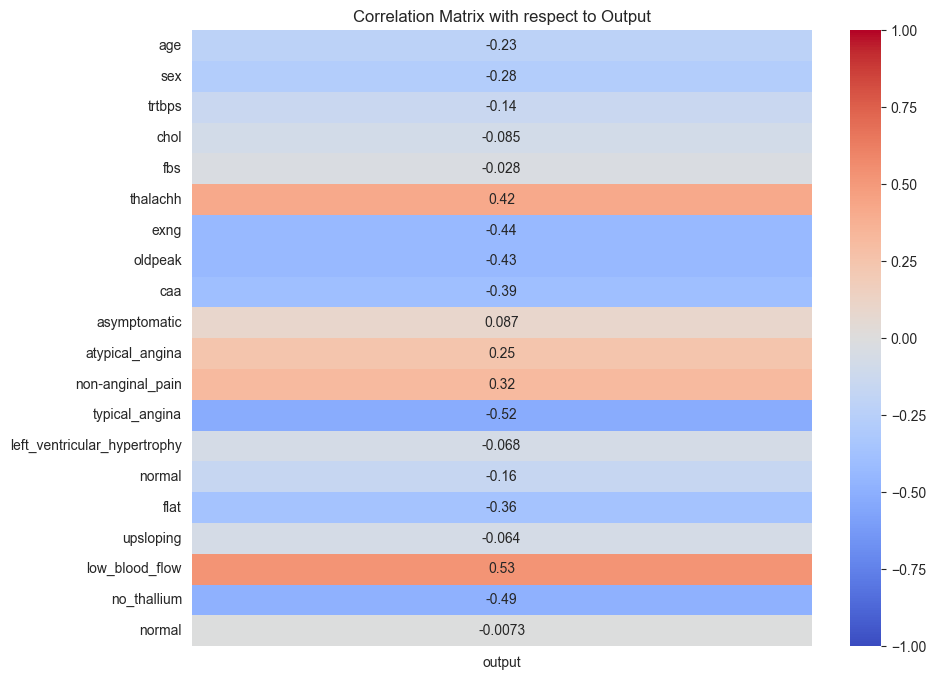

In [24]:
correlation_matrix = df.corr()
output_correlation = correlation_matrix[['output']].drop('output')
plt.figure(figsize=(10, 8))
sns.heatmap(output_correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix with respect to Output')
plt.show()

In [25]:
col_to_use: DataFrame = (output_correlation < -0.3) | (output_correlation > -0.05)
col_to_use = col_to_use[col_to_use['output']].index
col_to_use

Index(['fbs', 'thalachh', 'exng', 'oldpeak', 'caa', 'asymptomatic',
       'atypical_angina', 'non-anginal_pain', 'typical_angina', 'flat',
       'low_blood_flow', 'no_thallium', 'normal'],
      dtype='object')

## Splitting the Data

In [26]:
X = df.drop('output', axis=1)
X = X[col_to_use]
y = df['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train a Logistic Regression Model

In [27]:
classifier = LogisticRegression(max_iter=2000)
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

## Evaluate the model

In [28]:
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.893     0.862     0.877        29
           1      0.879     0.906     0.892        32

    accuracy                          0.885        61
   macro avg      0.886     0.884     0.885        61
weighted avg      0.885     0.885     0.885        61



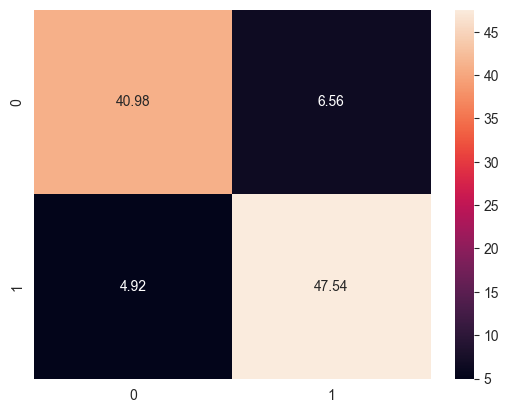

In [29]:
results = confusion_matrix(y_test, y_pred)

results = results / results.sum() * 100
sns.heatmap(results, annot=True, fmt=".2f")

# plt.xticks([0.5, 1.5], labels)
# plt.yticks([0.5, 1.5], labels)
plt.show()